In [3]:
import numpy as np
import seaborn as sns
from matplotlib import pyplot as plt
from utils import abovethreshold_exante, abovethreshold_expost, calc_sigmas
def simulate_stopping_time(rho, sigmaX, sigmaZ, n_trials=10_000, k_max=200):
    ''' Simulate the stopping time of AboveThreshold against a worst-case dataset for 
        public threshold $\\rho$, threshold noise $\\sigma_X$ and query noise $\\sigma_Z$.
    '''
    stop_times = []
    for _ in range(n_trials):
        rho_hat = rho + np.random.normal(0, scale=sigmaX)
        q_hats = np.random.normal(0, scale=sigmaZ, size=k_max)
        times = np.where(q_hats > rho_hat)[0]
        
        # check if there exists a stopping time and get the first stopping time:
        stop_time = times[0] if len(times) > 0 else k_max
        stop_times.append(stop_time)
    stop_times.sort()
    stop_times = stop_times[::-1]
    return {
        'median': np.median(stop_times),
        'p80': np.percentile(stop_times, 80),
    }
def map_stoptime_to_dimension_index(stop_time, stopping_ts):
    '''expects a sorted list of dimensions. returns the index which is closest to the stop time'''
    for i, t in enumerate(stopping_ts):
        if stop_time >= t:
            return i - 1


N = 1000
pts=20
sigmas = np.linspace(.2, 0.3, pts)
stopping_ts = np.linspace(50, 3, pts, dtype=int)
thresholds = [.50, .6500, .750]
boty, topy = 1, 0
GS=1/N
dps=25

In [6]:
# Run experiment:
results = {}
for rho in thresholds:
    # Compute exante and expost:
    exante = np.zeros((len(stopping_ts), len(sigmas)))
    expost = np.zeros((len(stopping_ts), len(sigmas)))
    for i, t in enumerate(stopping_ts):
        for j, sigma in enumerate(sigmas):
            sigmaX, sigmaZ = calc_sigmas(sigma)
            args = dict(sigmaX=sigmaX, sigmaZ=sigmaZ, t=t, GS=GS, rho=rho, topy=topy, boty=boty, dps=dps, delta=delta)
            exante[i,j] = abovethreshold_exante(**args)
            expost[i,j] = abovethreshold_expost(**args)
            print(f'[{t}, {sigma:.3f}] {exante[i,j]:.3f}, {expost[i,j]:.3f}, delta: {(exante[i,j] - expost[i,j]):.3f}', end="\r")
    # Simulate stopping times
    stopping_times = {}
    for j, sigma in enumerate(sigmas):        
        stopping_times[sigma] = simulate_stopping_time(rho, *calc_sigmas(sigma))
    
    results[rho] = {'expost': expost, 'exante': exante, 'delta': np.maximum(exante - expost, -1.), 'stopping_times': stopping_times}

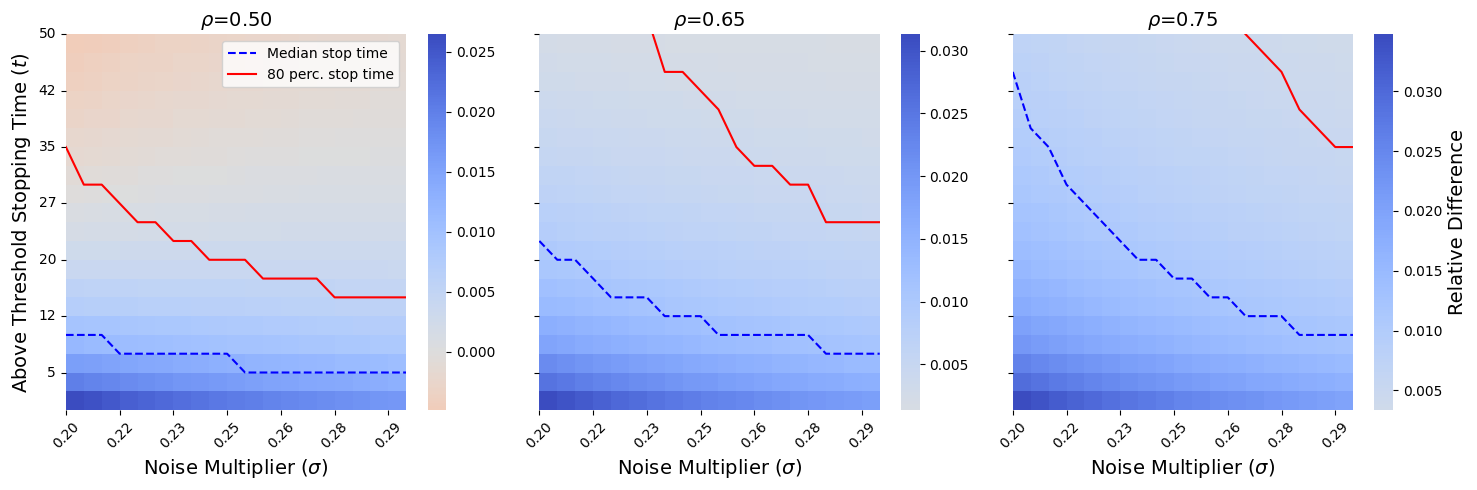

In [10]:

fig, axs = plt.subplots(1, len(thresholds), figsize=(15,5), sharex=True, sharey=True)
ax = axs
for idx, rho in enumerate(results.keys()):
    ax = axs[idx]
    warm_cool = plt.colormaps.get_cmap('coolwarm_r')
    cbar_kws = None
    if idx == 2:
        cbar_kws = {'label': 'Relative Difference'}
    sns.heatmap(results[rho]['delta'], linewidth=0.00, cmap=warm_cool, center=0., ax=ax, annot=False, cbar=True, fmt=".3f", annot_kws={"fontsize":12}, cbar_kws=cbar_kws)
    ax.figure.axes[-1].yaxis.label.set_size(14)

    ys = [results[rho]['stopping_times'][sigma]['median'] for sigma in sigmas]
    ys = [map_stoptime_to_dimension_index(y, stopping_ts) for y in ys]
    ax.plot(np.arange(pts), ys, color='blue', linestyle='--', linewidth=1.5, label='Median stop time')
    
    ys = [results[rho]['stopping_times'][sigma]['p80'] for sigma in sigmas]
    ys = [map_stoptime_to_dimension_index(y, stopping_ts) for y in ys]
    
    ax.plot(np.arange(pts), ys, color='red', linestyle='-', linewidth=1.5, label='80 perc. stop time')
    ax.set_title(f"$\\rho $={rho:.2f}", fontsize=14)
    ax.set_xticks(np.arange(len(sigmas), step=3), [f'{s:.2f}' for (i, s) in enumerate(sigmas) if (i % 3) == 0], rotation=45)
    ax.set_yticks(np.arange(len(stopping_ts), step=3), [t for (i, t) in enumerate(stopping_ts) if (i % 3) == 0] , rotation=0)
    if idx == 0:
        ax.set_ylabel('Above Threshold Stopping Time ($t$)', fontsize=14)
        ax.legend()
    ax.set_xlabel('Noise Multiplier ($\\sigma$)', fontsize=14)
    ax.set_xlim(0, pts - 1)
fig.tight_layout()